In [21]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [2]:
def evaluate_predictions(model, dataset_type, y_pred, y_truth):
    rmse = np.round(np.sqrt(mean_squared_error(y_truth, y_pred)), 0)
    mae = np.round(median_absolute_error(y_truth, y_pred), 0)
    return {'model': [model], 'dataset_type': [dataset_type], 'rmse':[rmse], 'mae': [mae]}

def diagnostics_plots(y_pred, y_truth):
    
    diag_plot = pd.DataFrame({'y_pred':y_pred,'y':y_truth, 'error': y_pred-y_truth})
    diag_plot.plot.scatter(x='y',y='y_pred')
    plt.plot([0,max(y_truth)], [0,max(y_truth)], c='black')
    plt.show()

In [3]:
l = sorted(glob.glob('datasets/*/free_agents_salaries_with_stats.csv'))

In [4]:
df = pd.concat([pd.read_csv(f) for f in l])

In [5]:
df = df[~df.team_id.isna()]

In [6]:
STATS_COLUMNS = ["player", "position", "age","team_id","g","gs","mp_per_g","fg_per_g",
"fga_per_g","fg_pct","fg3_per_g","fg3a_per_g","fg3_pct","fg2_per_g","fg2a_per_g",
"fg2_pct","efg_pct","ft_per_g","fta_per_g","ft_pct","orb_per_g","drb_per_g","trb_per_g",
"ast_per_g","stl_per_g","blk_per_g","tov_per_g","pf_per_g","pts_per_g"]
NUM_STATS_COLUMNS = [col for col in STATS_COLUMNS if col not in ('"player", "position","team_id"')]

ADVANCED_STATS_COLUMNS =["player","position","age","team_id","g","mp","per","ts_pct","fg3a_per_fga_pct",
"fta_per_fga_pct","orb_pct","drb_pct","trb_pct","ast_pct","stl_pct","blk_pct","tov_pct","usg_pct",
                         "ows","dws","ws","ws_per_48","obpm","dbpm","bpm","vorp"]

NUM_ADVANCED_STATS_COLUMNS = [col for col in ADVANCED_STATS_COLUMNS if col not in ('"player", "position","team_id"')]
INJURIES_COLUMNS = ['out_for_season', 'out_indefinitely','acum_out_for_season', 'acum_out_indefinitely']

In [7]:
year=[2012,2013,2014,2015,2016,2017,2018, 2019, 2020]
min_salary =[473604, 473604, 490180, 507336, 525093, 543471, 815615, 838464, 898310]
min_salary_df = pd.DataFrame({'free_agency_year':year, 'min_salary':min_salary})

In [8]:
df =  pd.merge(df, min_salary_df).query('mean_salary>min_salary').drop(columns='min_salary')

In [9]:
# Generar info para todos los anos, hay faltantes
injuries = pd.read_csv('datasets/full_injuries.csv')
df = pd.merge(df, injuries, how='left', left_on=['player', 'free_agency_year'], right_on=['player', 'year'])

In [10]:
df = df.drop(columns=['ws-dum', 'bpm-dum']).fillna(0)

In [11]:
relevant_cols = list(set(NUM_STATS_COLUMNS + NUM_ADVANCED_STATS_COLUMNS + ['position'] + INJURIES_COLUMNS))

In [12]:
X = df[relevant_cols+['free_agency_year']]
y = df[['mean_salary','free_agency_year']]

In [13]:
X['position'] = X.position.str.split('-').apply(lambda x: x[0])
X = pd.get_dummies(X, columns=["position"])

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
train_X, test_X = X.query('free_agency_year < 2020').drop('free_agency_year', axis=1).values,\
                  X.query('free_agency_year == 2020').drop('free_agency_year', axis=1).values
train_y, test_y = y.query('free_agency_year < 2020').drop('free_agency_year', axis=1).mean_salary.values,\
                    y.query('free_agency_year == 2020').drop('free_agency_year', axis=1).mean_salary.values

### Regresión lineal

In [15]:
?sm.OLS

In [16]:
mod = sm.OLS(train_y, train_X, hasconst=True)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     35.29
Date:                Sun, 13 Jun 2021   Prob (F-statistic):          1.72e-183
Time:                        18:17:33   Log-Likelihood:                -15358.
No. Observations:                 925   AIC:                         3.083e+04
Df Residuals:                     869   BIC:                         3.110e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.578e+06   6.03e+06     -0.759      0.4

In [17]:
gamma_model = sm.GLM(endog=train_y, exog=train_X, family=sm.families.Gamma(link=sm.families.links.log))

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


In [18]:
gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  925
Model:                            GLM   Df Residuals:                      869
Model Family:                   Gamma   Df Model:                           55
Link Function:                    log   Scale:                         0.42470
Method:                          IRLS   Log-Likelihood:                -14899.
Date:                Sun, 13 Jun 2021   Deviance:                       326.99
Time:                        18:17:33   Pearson chi2:                     369.
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7411      0.969      0.765      0.4

In [19]:
train_y_pred = gamma_results.predict(train_X)

In [22]:
evaluate_predictions('xgboost', 'test', train_y_pred, train_y)

{'model': ['xgboost'],
 'dataset_type': ['test'],
 'rmse': [4435408.0],
 'mae': [1666077.0]}

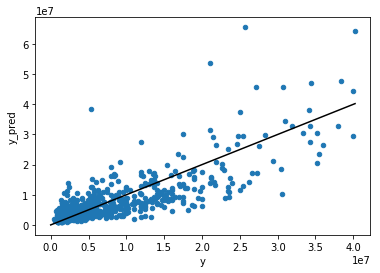

In [23]:
diagnostics_plots(train_y_pred, train_y)

In [25]:
test_y_pred = gamma_results.predict(test_X)

In [26]:
evaluate_predictions('modelo lineal', 'test', test_y_pred, test_y)

{'model': ['modelo lineal'],
 'dataset_type': ['test'],
 'rmse': [4862778.0],
 'mae': [1456809.0]}

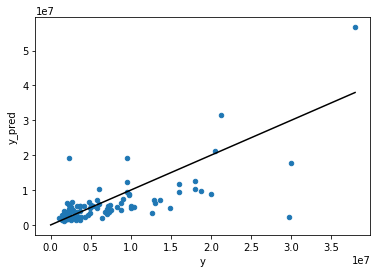

In [27]:
diagnostics_plots(test_y_pred, test_y)